In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [37]:
# Step 1: Data Collection
# Load data and drop the second row (index=1)
data = pd.read_csv('gold_and_macro_data_final.csv')
data = data.drop(0)
data.head(5)
# Step 2: Data Preprocessing
data.fillna(method='ffill', inplace=True)
data.head(5)

C:\Users\NBODT\AppData\Local\Temp\ipykernel_21488\940339410.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,Date,Gold_Price_USD,Silver_Price_USD,Crude_Oil_Price,SP500_Index,US_10Y_Treasury_Yield,US_Dollar_Index_DXY,GLD_ETF_Price
1,2015-07-10,1157.699951171875,15.468000411987305,52.7400016784668,2076.6201171875,2.4170000553131104,96.02999877929688,111.48999786376953
2,2015-07-13,1155.199951171875,15.435999870300293,52.20000076293945,2099.60009765625,2.430000066757202,96.86000061035156,110.98999786376953
3,2015-07-14,1153.300048828125,15.295000076293945,53.040000915527344,2108.949951171875,2.3989999294281006,96.63999938964844,110.73999786376953
4,2015-07-15,1147.199951171875,15.027999877929688,51.40999984741211,2107.39990234375,2.3499999046325684,97.12999725341797,110.16000366210938
5,2015-07-16,1143.800048828125,14.96399974822998,50.90999984741211,2124.2900390625,2.3519999980926514,97.66000366210938,109.76000213623047


In [38]:
# Feature Engineering: Create lagged features
for lag in range(1, 6):
    data[f'lag_{lag}'] = data['Gold_Price_USD'].shift(lag)

In [39]:
data.dropna(inplace=True)

In [40]:
# Check for null values in the dataframe
print(data.isnull().sum())

Date                     0
Gold_Price_USD           0
Silver_Price_USD         0
Crude_Oil_Price          0
SP500_Index              0
US_10Y_Treasury_Yield    0
US_Dollar_Index_DXY      0
GLD_ETF_Price            0
lag_1                    0
lag_2                    0
lag_3                    0
lag_4                    0
lag_5                    0
dtype: int64


In [41]:
# Define features and target
X = data[['Silver_Price_USD', 'Crude_Oil_Price',
          'SP500_Index', 'US_10Y_Treasury_Yield', 'US_Dollar_Index_DXY',
          'GLD_ETF_Price', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
y = data['Gold_Price_USD']

In [42]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
# สร้าง Dictionary ของโมเดลที่จะใช้
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# ฝึกโมเดลแต่ละตัว
print("\n--- Starting Model Training ---")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
print("✅ Model training complete.")


--- Starting Model Training ---
Training Linear Regression...
Training Random Forest...
Training XGBoost...
✅ Model training complete.


In [44]:
# Step 5.5: Cross-Validation Score
print("\n--- Running 5-Fold Cross-Validation ---")
for name, model in models.items():
    # สร้าง Pipeline เพื่อรวมการทำ Scaling และการรันโมเดลเข้าด้วยกัน
    # เพื่อป้องกัน Data Leakage ในระหว่าง Cross-validation
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                               ('model', model)])
    
    # คำนวณ CV score โดยใช้ข้อมูลทั้งหมด (X, y)
    # scoring='neg_mean_absolute_error' จะให้ค่าติดลบของ MAE
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    
    # แปลงกลับเป็นค่าบวกและแสดงผล
    mean_cv_mae = -np.mean(cv_scores)
    std_cv_mae = np.std(cv_scores)
    
    print(f"\n--- {name} (Cross-Validation) ---")
    print(f"Average MAE from CV: {mean_cv_mae:.2f} (std: {std_cv_mae:.2f})")


--- Running 5-Fold Cross-Validation ---

--- Linear Regression (Cross-Validation) ---
Average MAE from CV: 4.98 (std: 1.65)

--- Random Forest (Cross-Validation) ---
Average MAE from CV: 103.62 (std: 173.41)

--- XGBoost (Cross-Validation) ---
Average MAE from CV: 108.34 (std: 175.71)


In [45]:
# Step 6: Model Evaluation
print("\n--- Model Evaluation Results ---")
results = {}
for name, model in models.items():
    # ทำการทำนายบนข้อมูล Test set
    y_pred = model.predict(X_test)
    
    # คำนวณค่า Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = [mae, rmse, r2]
    
    # แสดงผล
    print(f"\n--- {name} ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")


--- Model Evaluation Results ---

--- Linear Regression ---
Mean Absolute Error (MAE): 3.86
Root Mean Squared Error (RMSE): 5.67
R-squared (R²): 0.9999

--- Random Forest ---
Mean Absolute Error (MAE): 4.73
Root Mean Squared Error (RMSE): 7.20
R-squared (R²): 0.9998

--- XGBoost ---
Mean Absolute Error (MAE): 5.96
Root Mean Squared Error (RMSE): 8.93
R-squared (R²): 0.9997


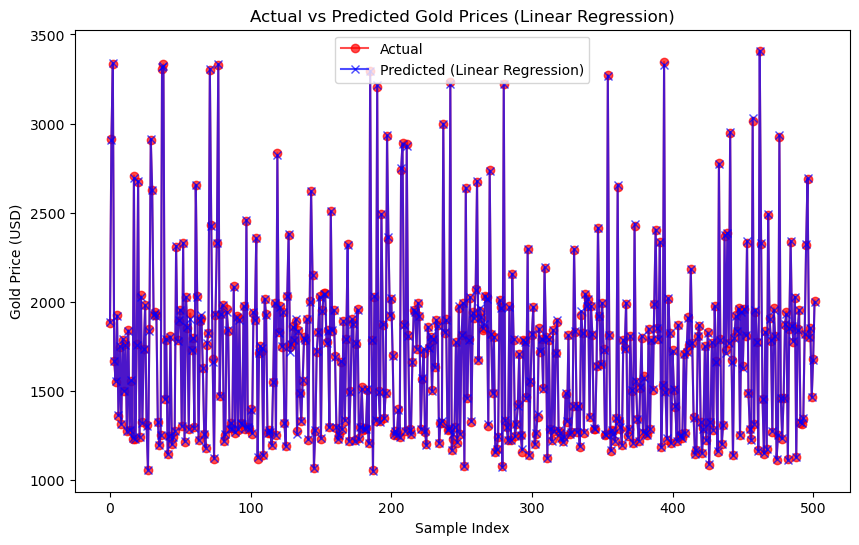

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values.astype(float), label='Actual', color='red', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred_lr, label='Predicted (Linear Regression)', color='blue', marker='x', linestyle='-', alpha=0.7)
plt.title('Actual vs Predicted Gold Prices (Linear Regression)')
plt.xlabel('Sample Index')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.show()
